# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load then save train, test, validation sets
def load_and_save():
    for path in ['dogImages/train', 'dogImages/valid', 'dogImages/test']:
        dog_files, dog_targets = load_dataset(path)
        print('saving files...')
        np.save(path + '/files.npy', dog_files)
        np.save(path + '/targets.npy', dog_targets)
        print('files saved!')

# Faster loading using numpy.load()
def fast_load_dataset(path):
    dog_files = np.load(path + '/files.npy')
    dog_targets = np.load(path + '/targets.npy')
    return dog_files, dog_targets

In [3]:
# load train, test, and validation datasets
train_files, train_targets = fast_load_dataset('dogImages/train')
valid_files, valid_targets = fast_load_dataset('dogImages/valid')
test_files, test_targets = fast_load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


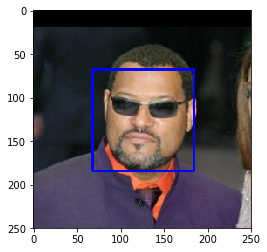

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [8]:
# function to assess detector function
def assess_detector(detector_function, img_paths):
    detected = 0
    for img_path in img_paths:
        if detector_function(img_path):
            detected += 1
    return detected / len(img_paths)

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces_percent = 100*assess_detector(face_detector, human_files_short)
dog_faces_percent = 100*assess_detector(face_detector, dog_files_short)

print("%.0f%% of the images in `human_files_short` have a detected face." % human_faces_percent)
print("%.0f%% of the images in `dog_files_short` have a detected face." % dog_faces_percent)

99% of the images in `human_files_short` have a detected face.
12% of the images in `dog_files_short` have a detected face.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?


__Answer:__

One method of detecting humans in images is to apply multiple cascade_classifiers (see human_detector below) and return True if any of them detect their target. human_detector() uses frontalface, profileface, upperbody, and lowerbody cascades. The detector is much slower than a single cascade and gives a very high false positive rate. The false positive rate cen be overcome by structuring the alorithm to detect dogs first and only after no dogs are detected run the human_detector. This works because ResNet-50 pretrained on ImageNet is very accurate for identifying dogs on the sample dataset (see question 3).

However, it is my opinion that constraining user-supplied images to only accept a clear view of a face is a reasonable expectation to pose on the user. First because human recognition in an arbitrary  user-supplied photo is a difficult task, perhaps even more challenging than dog-breed classification from an arbitrary user-supplied photo. Simpler solutions are better than complex ones and adding vountary constraints to the photos is much more efficient than engineering a complex solution. Second, the intent behind building that functionality into the program is to return the resembling dog breed and its is most likely that the system will do so in a human understandable way with restricted inputs.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [10]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

In [10]:
# extract pre-trained lbpcascade_frontalface_improved face detector
face_cascade = cv2.CascadeClassifier('lbpcascades/lbpcascade_frontalface_improved.xml')

human_faces_percent = 100*assess_detector(face_detector, human_files_short)
dog_faces_percent = 100*assess_detector(face_detector, dog_files_short)

print("%.0f%% of the images in `human_files_short` have a detected face." % human_faces_percent)
print("%.0f%% of the images in `dog_files_short` have a detected face." % dog_faces_percent)

93% of the images in `human_files_short` have a detected face.
1% of the images in `dog_files_short` have a detected face.


In [11]:
# extract pre-trained haarcascade_frontalface_alt2 face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

human_faces_percent = 100*assess_detector(face_detector, human_files_short)
dog_faces_percent = 100*assess_detector(face_detector, dog_files_short)

print("%.0f%% of the images in `human_files_short` have a detected face." % human_faces_percent)
print("%.0f%% of the images in `dog_files_short` have a detected face." % dog_faces_percent)

100% of the images in `human_files_short` have a detected face.
19% of the images in `dog_files_short` have a detected face.


In [12]:
# returns "True" if human is detected in image stored at img_path
# Note: very high false positive rate
def human_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # define multiple face cascades
    frontal_face = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
    profile_face = cv2.CascadeClassifier('haarcascades/haarcascade_profileface.xml')
    upper_body = cv2.CascadeClassifier('haarcascades/haarcascade_upperbody.xml')
    full_body = cv2.CascadeClassifier('haarcascades/haarcascade_fullbody.xml')
    
    for cascade in [frontal_face, profile_face, upper_body, full_body]:
        humans = cascade.detectMultiScale(gray)
        if len(humans) > 0:
            return True
    return False

In [13]:
human_humans_percent = 100*assess_detector(human_detector, human_files_short)
dog_humans_percent = 100*assess_detector(human_detector, dog_files_short)

print("%.0f%% of the images in `human_files_short` have a detected face." % human_humans_percent)
print("%.0f%% of the images in `dog_files_short` have a detected face." % dog_humans_percent)

100% of the images in `human_files_short` have a detected face.
38% of the images in `dog_files_short` have a detected face.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [14]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [5]:
from keras.preprocessing import image                  
#from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [6]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [18]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_dogs_percent = 100*assess_detector(dog_detector, human_files_short)
dog_dogs_percent = 100*assess_detector(dog_detector, dog_files_short)

print("%.0f%% of the images in `human_files_short` have a detected dog." % human_dogs_percent)
print("%.0f%% of the images in `dog_files_short` have a detected dog." % dog_dogs_percent)

1% of the images in `human_files_short` have a detected dog.
100% of the images in `dog_files_short` have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [8]:
# preprocess and save tensors with np.savez
# load with np.load('dogImages/tensors.npz')
def save_tensors():
    train = paths_to_tensor(train_files).astype('float32') / 255
    test = paths_to_tensor(test_files).astype('float32') / 255
    valid = paths_to_tensor(valid_files).astype('float32') / 255
    # save tensors
    print("saving tensors...")
    np.savez('dogImages/tensors.npz', train=train, test=test, valid=valid)
    print("all tensors successfully saved!")

In [9]:
# pre-process the data for Keras
tensors = np.load('dogImages/tensors.npz')
train_tensors = tensors['train']
valid_tensors = tensors['valid']
test_tensors = tensors['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)


In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Activation, BatchNormalization, ZeroPadding2D
from keras.models import Sequential

In [13]:
def model_from_scratch(number_of_labels, 
                       first_filters=32, input_shape=(224, 224, 3)):
    model = Sequential()

    # first layer
    model.add(Conv2D(filters=first_filters, input_shape=input_shape,
                     kernel_size=2, strides=2,  name='first_conv'))
    model.add(BatchNormalization(name='first_bn'))
    model.add(Activation('relu', name='first_relu'))
    model.add(MaxPooling2D(pool_size=2, name='first_2x2'))
    
    # second layer
    model.add(Conv2D(filters=first_filters*2, 
                     kernel_size=2, strides=2, name='second_conv'))
    model.add(BatchNormalization(name='second_bn'))
    model.add(Activation('relu', name='second_relu'))
    model.add(MaxPooling2D(pool_size=2, name='second_2x2'))
    
    # third layer
    model.add(Conv2D(filters=first_filters*4, 
                     kernel_size=2, strides=2, name='third_conv'))
    model.add(BatchNormalization(name='third_bn'))
    model.add(Activation('relu', name='thrid_relu'))
    model.add(MaxPooling2D(pool_size=2, name='third_2x2'))
    
    #
    model.add(GlobalAveragePooling2D(name='final'))
    model.add(Dense(units=number_of_labels, name='final_labels'))
    model.add(Activation('softmax', name='final_softmax'))
    return model

In [25]:
def idk_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, input_shape=(224, 224, 3),
                     kernel_size=(1,1), strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='first_2x2'))
    
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='second_2x2'))
    
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, name='third_2x2'))
    
    model.add(GlobalAveragePooling2D(name='final'))
    model.add(Dense(units=133, name='final_labels'))
    model.add(Activation('softmax', name='final_softmax'))
    
    return model


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.


__Answer:__ 

The neural network architecture needs to map the input volume (the raw pixel values of the image) into a vector of the class scores. In this instance it needs to transform the 224x224x3 input into a 1x1x133 vector. The basic architecture is to use convolutional layers as feature extractors and a final fully connected layer to map the features to the classes.

A simple convolutional network architecture is "INPUT -> [[CONV -> RELU]\*N -> POOL?]\*M -> [FC -> RELU]\*K -> FC" [(source)](https://cs231n.github.io/convolutional-networks/#layerpat). The hint model follws this pattern with N=1, M=3, and K=0.

The reason this architecture works well for this image classification task, is that each block of [CONV -> RELU -> POOL] transforms its input by increasing the depth (the feature maps) while decreasing the width and height. Stacking these blocks on top of each other allows for subsequent convolutional layers to discover higher level features as deeper layers have a larger effective receptive field size relative to the original input image. This block architecture also lends itself to a clear division of roles for each layer: the convolutional layers transform the input depth and the pool layers tranform the input width and height.

Note that the final CNN arhitecture differs from the hint model and simple architeture in the hyperparameters. Mostly the stride of the convolutional layers is increased to 2 from 2, meaning the convolutional layers also reduce the width and height of the input as well as increse the depth. This is done to speed up training time with small loss in final test accuracy. Batch normalization has been added between the convolutional layers and the ReLU layers to increase accuracy.

In [26]:
### TODO: Define your architecture.
#model = model_from_scratch(133)
model = idk_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      64        
_________________________________________________________________
first_2x2 (MaxPooling2D)     (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
second_2x2 (MaxPooling2D)    (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 32)        4128      
_________________________________________________________________
third_2x2 (MaxPooling2D)     (None, 27, 27, 32)        0         
_________________________________________________________________
final (GlobalAveragePooling2 (None, 32)                0         
__________

### Compile the Model

In [27]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
from keras.callbacks import ModelCheckpoint

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 1

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1
6660/6680 [============================>.] - ETA: 0s - loss: 4.8863 - acc: 0.0087
Epoch 00001: val_loss improved from inf to 4.87238, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 149s 22ms/step - loss: 4.8863 - acc: 0.0087 - val_loss: 4.8724 - val_acc: 0.0096


### Load the Model with the Best Validation Loss

In [33]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [34]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.2297%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [35]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [36]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [37]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [38]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6460/6680 [============================>.] - ETA: 0s - loss: 12.4985 - acc: 0.1149
Epoch 00001: val_loss improved from inf to 11.24273, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 358us/step - loss: 12.4488 - acc: 0.1177 - val_loss: 11.2427 - val_acc: 0.1952
Epoch 2/20
6440/6680 [===========================>..] - ETA: 0s - loss: 10.4331 - acc: 0.2640
Epoch 00002: val_loss improved from 11.24273 to 10.41025, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 217us/step - loss: 10.4243 - acc: 0.2647 - val_loss: 10.4103 - val_acc: 0.2611
Epoch 3/20
6640/6680 [============================>.] - ETA: 0s - loss: 9.8961 - acc: 0.3206
Epoch 00003: val_loss improved from 10.41025 to 10.15658, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 1s 222us/step - loss: 9.8961 - acc: 0.3210 - 

### Load the Model with the Best Validation Loss

In [39]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [40]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.5407%


### Predict Dog Breed with the Model

In [41]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [42]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.



__Answer:__ 

The main insight is realizing that the ResNet-50 model takes the role of [fixed feature extractor](https://cs231n.github.io/transfer-learning/) and all that's necessary to do is to train a linear classifier to map these features to the desired labels. This means a fully connected layer with 133 units and softmax activation layer. The choice of the Flatten layer comes from the keras implementation of ResNet-50 [(github)](https://github.com/keras-team/keras/blob/master/keras/applications/resnet50.py) 

This architecture is suitable for the current problem because the ResNet-50 model with weights pretrained on ImageNet already does well in extracting features relevant to dog breeds. ImageNet has a suprisingly large number of dog breeds as labels (110 out of 1000), meaning any model that does well on ImageNet is more likely to have captured features relevant to the dog dataset. The only thing left to do is train a linear classifier to map those features to the desired 133 labels.

In [43]:
### TODO: Define your architecture.
def transfer_learning_resnet50(classes, input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape, name='extracted_features'))
    model.add(Dense(133, name='labels'))
    model.add(Activation('softmax', name='softmax'))
    
    weight_path = 'saved_models/weights.best.Resnet50.hdf5'
    return model, weight_path

In [44]:
resnet50_model, resnet50_weights = transfer_learning_resnet50(133, train_resnet50.shape[1:])
resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
extracted_features (Flatten) (None, 2048)              0         
_________________________________________________________________
labels (Dense)               (None, 133)               272517    
_________________________________________________________________
softmax (Activation)         (None, 133)               0         
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [45]:
### TODO: Compile the model.
resnet50_model.compile(loss='categorical_crossentropy', 
                       optimizer='rmsprop', 
                       metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [46]:
### TODO: Train the model.
epochs=5
batch_size=20

checkpointer = ModelCheckpoint(filepath=resnet50_weights,
                               verbose=1, save_best_only=True)

resnet50_model.fit(train_resnet50, train_targets,
                   validation_data=(valid_resnet50, valid_targets),
                   epochs=epochs, batch_size=batch_size,
                   callbacks=[checkpointer], 
                   verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6480/6680 [============================>.] - ETA: 0s - loss: 1.6441 - acc: 0.5981
Epoch 00001: val_loss improved from inf to 0.82169, saving model to saved_models/weights.best.Resnet50.hdf5
6680/6680 [==============================] - 3s 412us/step - loss: 1.6171 - acc: 0.6037 - val_loss: 0.8217 - val_acc: 0.7509
Epoch 2/5
6540/6680 [============================>.] - ETA: 0s - loss: 0.4379 - acc: 0.8641
Epoch 00002: val_loss improved from 0.82169 to 0.72579, saving model to saved_models/weights.best.Resnet50.hdf5
6680/6680 [==============================] - 2s 271us/step - loss: 0.4387 - acc: 0.8648 - val_loss: 0.7258 - val_acc: 0.7904
Epoch 3/5
6600/6680 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.9180
Epoch 00003: val_loss improved from 0.72579 to 0.64434, saving model to saved_models/weights.best.Resnet50.hdf5
6680/6680 [==============================] - 2s 275us/step - loss: 0.2615 - acc: 0.9175 - val_l

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [47]:
### TODO: Load the model weights with the best validation loss.
resnet50_model.load_weights(resnet50_weights)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [48]:
### TODO: Calculate classification accuracy on the test dataset.
predictions = [np.argmax(resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]
test_accuracy = 100 * np.sum(np.array(predictions) == np.argmax(test_targets, axis=1)) / len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.7416%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [49]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [50]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

In [55]:
def main(img_path):
    if dog_detector(img_path):
        # dog detected
        print("Dog Image")
        dog_breed = resnet50_predict_breed(img_path)
        print("Dog is likely", dog_breed)
    elif face_detector(img_path):
        # human face detected
        print("Human Image")
        dog_breed = resnet50_predict_breed(img_path)
        print("Human resembles", dog_breed)
    else:
        # Unknown
        print("Unkown Image")
    plt.imshow(cv2.imread(img_path))
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ 
The output for dog images is about expected with 80% accuracy. It is much better than the  study that found human experts correctly "correctly identified a prominent breed an average of 27% of the time" [(source)](https://vetmed-maddie.sites.medinfo.ufl.edu/files/2012/05/2012-Croy-Maddies-Shelter-Medicine-Confernce-Abstract.pdf). The output for the human images seems largely random.

First Improvement: Data Augmentation using ImageDataGenerator() method from keras. Additionally, focus on errors found in the confusion matrix, the dog breeds that the algorithm misclassifies.

Second Improvement: Implement Cyclical Learning Rate [(paper)](https://arxiv.org/abs/1506.01186) and [(github)](https://github.com/bckenstler/CLR).

Third Improvement: Fine-tune the weights of the finals layers of the pretrained ResNet50 model by continuing the backpropagation. Specifically only the three stage 5 blocks (lines 233 to 235 in [github](https://github.com/keras-team/keras/blob/master/keras/applications/resnet50.py)).

Fourth Improvement: Add an image of the resembling dog breed to the output of a human image. This would theoretically increase the understandability of thay functionality as currently there seems to be no reason a human image is classified as resembling a specific dog breed.

In [75]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [76]:
def test_with_dog_image():
    index = np.random.choice(range(len(valid_files)))
    print(index)
    main(valid_files[index])
    print('dog is actually: ' + dog_names[np.argmax(valid_targets[index])])

def test_with_human_image():
    index = np.random.choice(range(len(human_files)))
    print(index)
    main(human_files[index])

testing dog images from dog_files
723
Dog Image
Dog is likely Havanese


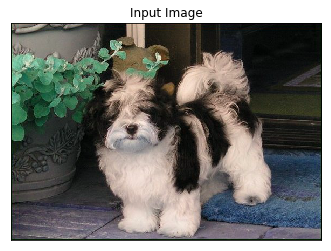

dog is actually: Havanese


233
Dog Image
Dog is likely Brussels_griffon


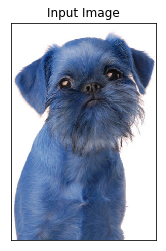

dog is actually: Brussels_griffon


820
Dog Image
Dog is likely French_bulldog


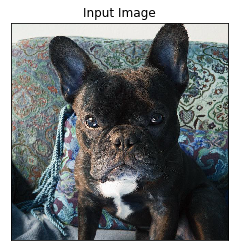

dog is actually: French_bulldog


721
Dog Image
Dog is likely Akita


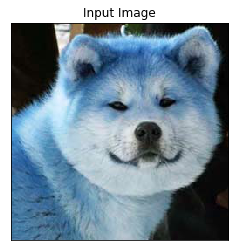

dog is actually: Akita


432
Dog Image
Dog is likely Beagle


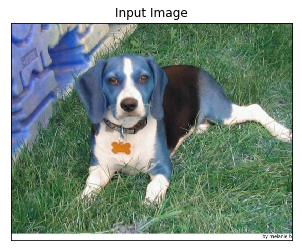

dog is actually: Beagle


451
Unkown Image


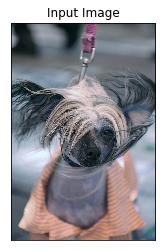

dog is actually: Chinese_crested




In [77]:
print('testing dog images from dog_files')
for i in range(6):
    test_with_dog_image()
    print('\n')

testing human images from human_files
2512
Human Image
Human resembles English_toy_spaniel


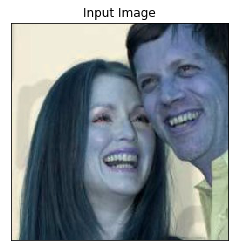



5228
Human Image
Human resembles Chinese_crested


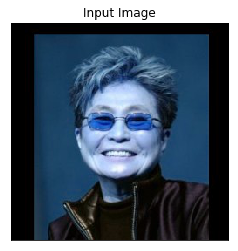



111
Human Image
Human resembles English_springer_spaniel


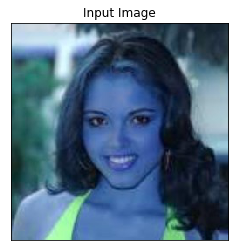



8286
Human Image
Human resembles English_toy_spaniel


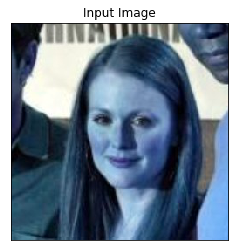



1514
Human Image
Human resembles Irish_water_spaniel


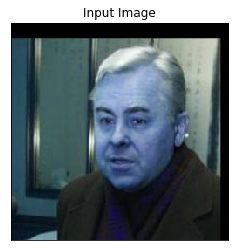



9970
Human Image
Human resembles Beagle


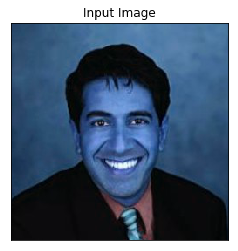

In [78]:
print('testing human images from human_files')
for i in range(6):
    test_with_human_image()
    print('\n')

In [119]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(test_targets, axis=1), predictions)

augmented_class_weights = [0] * 133

for index in range(len(cnf_matrix)):
    print(dog_names[index])
    for element in np.nonzero(cnf_matrix[index])[0]:
        if element != index:
            augmented_class_weights[index] += 1
            print('\t'+dog_names[element])

Affenpinscher
	Lhasa_apso
Afghan_hound
	Irish_wolfhound
Airedale_terrier
	Irish_terrier
Akita
	Alaskan_malamute
	Norwegian_lundehund
Alaskan_malamute
American_eskimo_dog
	Pomeranian
American_foxhound
	Beagle
American_staffordshire_terrier
American_water_spaniel
	Boykin_spaniel
	Flat-coated_retriever
Anatolian_shepherd_dog
	American_foxhound
	Mastiff
Australian_cattle_dog
	Canaan_dog
Australian_shepherd
	Brittany
	English_setter
	Nova_scotia_duck_tolling_retriever
Australian_terrier
	Norwich_terrier
Basenji
	Cardigan_welsh_corgi
Basset_hound
	American_foxhound
Beagle
	American_foxhound
Bearded_collie
	American_staffordshire_terrier
Beauceron
	Doberman_pinscher
Bedlington_terrier
Belgian_malinois
Belgian_sheepdog
	Giant_schnauzer
Belgian_tervuren
Bernese_mountain_dog
	English_toy_spaniel
Bichon_frise
	Havanese
Black_and_tan_coonhound
Black_russian_terrier
	Giant_schnauzer
	Kerry_blue_terrier
Bloodhound
Bluetick_coonhound
	Entlebucher_mountain_dog
Border_collie
Border_terrier
Borzoi
	Aust

In [120]:
print(augmented_class_weights)

[1, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 3, 0, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 3, 0, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 0, 2, 1, 0, 1, 2, 1, 1, 1, 0, 3, 2, 1, 2, 1, 3, 1, 0, 0, 1, 0, 1, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 3, 1, 1, 4, 0, 1, 1, 2, 2, 0, 0, 2]
